In [1]:
# importing required libraries
import torch.nn as nn
import torch
import warnings
import math
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn.functional as F
from model import TFModel
import Rotary_test
import utils
import data

warnings.simplefilter("ignore")
utils.fix_random_seed(42)

class Config:
    """
    This is the configuration class to store the configuration of a TFModel. It is used to
    instantiate a model according to the specified arguments, defining the model architecture.
    """

    def __init__(self, **kwargs):
        self.__dict__.update(kwargs)

In [2]:
# loading config file
dirname = "2_layer_64_vocab_old"
with open(f"data/{dirname}/config.json") as f:
    config_args = json.load(f)
    config_args["rotary_theta"] = 10000
config = Config(**config_args)

d_model = config.d_model
num_heads = config.num_heads
max_seq_len = config.max_seq_len
rotary_theta = config.rotary_theta

In [3]:
R = Rotary_test.calc_rotary_R_mat_simple(d_model, rel_dist=1)
print(R.shape)

torch.Size([64, 64])


In [4]:
# loading model checkpoint (which I cached from earlier experiments)
if config.device == "cuda":
    checkpoint = torch.load(f"data/{dirname}/ckpt.pt", map_location=torch.device('cpu'))
    config.device = "cpu"

config.trainable_norm = True

model = TFModel(config)

model.load_state_dict(checkpoint, strict=False)
model.eval()

TFModel(
  (embed): Embedding(
    (embed): Embedding(64, 64)
  )
  (h): ModuleList(
    (0-1): 2 x TFBlock(
      (mha): MultiHeadAttention(
        (W_q): Linear(in_features=64, out_features=64, bias=True)
        (W_k): Linear(in_features=64, out_features=64, bias=True)
        (W_v): Linear(in_features=64, out_features=64, bias=True)
        (W_o): Linear(in_features=64, out_features=64, bias=True)
      )
      (ln_1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (ln_2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (dropout1): Dropout(p=0.1, inplace=False)
      (dropout2): Dropout(p=0.1, inplace=False)
    )
  )
  (ln_f): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
  (fc): Linear(in_features=64, out_features=64, bias=True)
)

### Token embeddings have 3 distinct singular subspaces

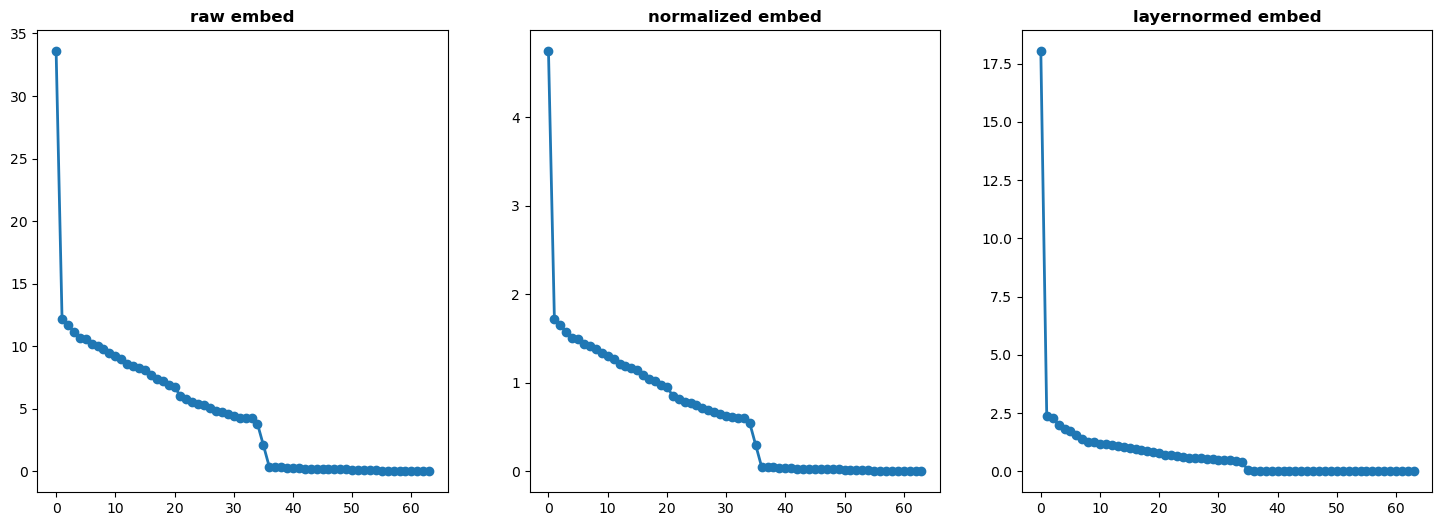

In [5]:
# get token embedding matrix, and also consider normalized embedding matrix. Unnormalized and normalized embeddings show similar structure.
W = model.embed.embed.weight.detach() # (vocab_size, d_model)
# W = (model.h[0].mha.W_o.weight.T @ model.h[0].mha.W_v.weight / math.sqrt(d_model)).detach()
W_nml = F.normalize(W, dim=1).detach()
W_ln = model.h[0].ln_1(W).detach()
U, s, Vt = torch.linalg.svd(W)
U2, s2, Vt2 = torch.linalg.svd(W_nml)
U3, s3, Vt3 = torch.linalg.svd(W_ln)

titles = ["raw embed", "normalized embed", "layernormed embed"]
fig, axs = plt.subplots(1, len(titles), figsize=(6*len(titles), 6*1))
for plt_idx, W_ in enumerate([W, W_nml, W_ln]):
    U_, s_, Vt_ = torch.linalg.svd(W_)
    axs[plt_idx].plot(range(len(s_)), s_, '-o', linewidth=2)
    axs[plt_idx].set_title(titles[plt_idx], weight="bold")

plt.show()

In [6]:
'''
plt.figure()
for load_epoch in range(0,10000,2000):
    checkpoint_ = torch.load(f"data/{dirname}/ckpt_{load_epoch}.pt", map_location=torch.device('cpu'))
    if config.device == "cuda":
        config.device = "cpu"
    config.trainable_norm = True
    model = TFModel(config)
    model.load_state_dict(checkpoint_, strict=False)
    model.eval()
    W = model.embed.embed.weight.detach()
    U, s, Vt = torch.linalg.svd(W)
    plt.plot(s, '-o')
plt.show()
'''

'\nplt.figure()\nfor load_epoch in range(0,10000,2000):\n    checkpoint_ = torch.load(f"data/{dirname}/ckpt_{load_epoch}.pt", map_location=torch.device(\'cpu\'))\n    if config.device == "cuda":\n        config.device = "cpu"\n    config.trainable_norm = True\n    model = TFModel(config)\n    model.load_state_dict(checkpoint_, strict=False)\n    model.eval()\n    W = model.embed.embed.weight.detach()\n    U, s, Vt = torch.linalg.svd(W)\n    plt.plot(s, \'-o\')\nplt.show()\n'

### bridge subspace are correlated with the highest level and lowest level in token embedding singular subspaces

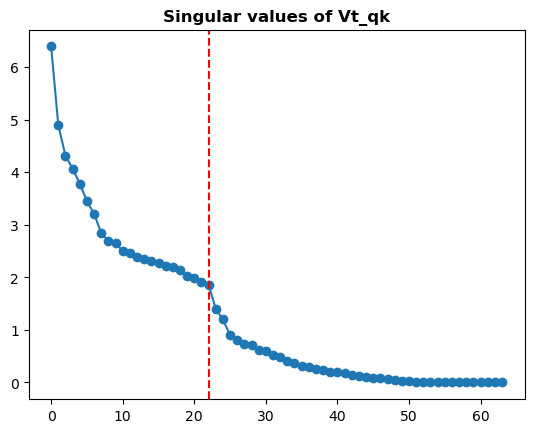

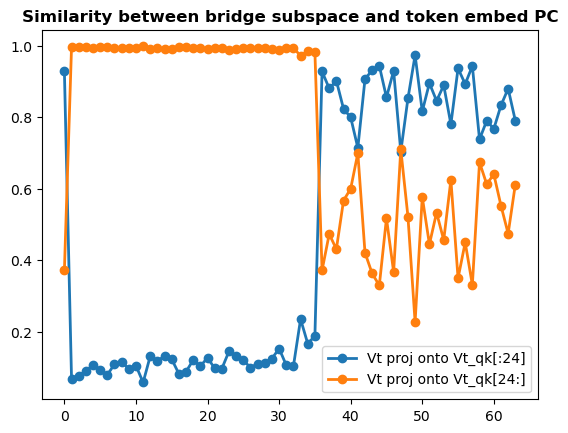

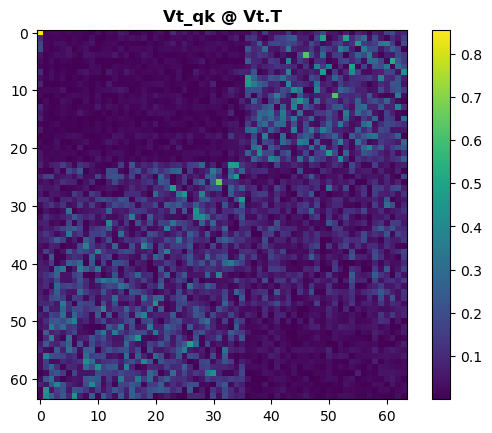

In [16]:
# calculate the bridge subspace (based on 2nd-layer QK) defined in the paper
W_qk = model.h[1].mha.W_q.weight.T @ model.h[1].mha.W_k.weight / math.sqrt(d_model) # only works for num_heads = 1 and ignoring rotary
U_qk, s_qk, Vt_qk = torch.linalg.svd(W_qk.detach())

plt.plot(s_qk, '-o')
plt.axvline(22, color='red', linestyle='--')
plt.title('Singular values of Vt_qk', weight='bold')
plt.show()

plt.plot(range(max_seq_len), [torch.norm(Vt_qk[:22] @ Vt[j]).item() for j in range(Vt.shape[0])], '-o', linewidth=2, label='Vt proj onto Vt_qk[:24]')
plt.plot(range(max_seq_len), [torch.norm(Vt_qk[22:] @ Vt[j]).item() for j in range(Vt.shape[0])], '-o', linewidth=2, label='Vt proj onto Vt_qk[24:]')
plt.title("Similarity between bridge subspace and token embed PC", weight="bold")
plt.legend()
plt.show()

plt.imshow(torch.abs(Vt_qk @ Vt.T), cmap='viridis')
plt.colorbar()
plt.title('Vt_qk @ Vt.T', weight='bold')
plt.show()


torch.Size([64, 64]) torch.Size([64, 64])


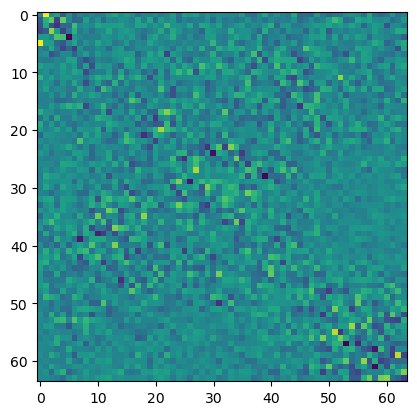

In [12]:
W_q = model.h[1].mha.W_q.weight.detach()
W_k = model.h[1].mha.W_k.weight.detach()
U_q, s_q, Vt_q = torch.linalg.svd(W_q)
U_k, s_k, Vt_k = torch.linalg.svd(W_k)
print(W_q.shape, W_k.shape)
plt.imshow(Vt_q @ Vt_k.T)
plt.show()